In [121]:
import torch
import torch.nn as nn
from torch.functional import F
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim
from tqdm import tqdm

In [122]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2 # Normalizes image values from [-1, 1](Due to Tanh activation) to [0, 1]
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [134]:
BATCH_SIZE = 128
SHUFFLE=True
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,)),])
epochs = 20
device='cuda' if torch.cuda.is_available() else 'cpu'
z_dim=64
lr=0.0002
beta_1 = 0.5
beta_2 = 0.999

In [124]:
dataset_train = datasets.MNIST('./data', train = True, transform = transform, download=True)
dataset_test = datasets.MNIST('./data', train = False, transform = transform, download=True)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [125]:
X, y = next(iter(dataloader_train))
X.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [126]:
def get_noise(n_samples, z_dim, device):
  return torch.randn((n_samples, z_dim), device=device)

In [127]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
    super().__init__()

    self.z_dim = z_dim
    self.hidden_dim = hidden_dim
    self.im_chan = im_chan

    self.gen = nn.Sequential(

      # INPUT: (B, C, H, W) | C=10, H=1, W=1
      self.make_gen_block(z_dim, hidden_dim * 4),
      # OUTPUT (H/W): (INPUT - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
      #               (1     - 1) * 2      - 2 * 0       + 1        * (3           - 1) + 0              + 1 = 3
      # OUTPUT: (B, C, H, W) | C=256, H=3, W=3


      # INPUT: (B, C, H, W) | C=256, H=3, W=3
      self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
      # OUTPUT (H/W): (INPUT - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
      #               (3     - 1) * 1      - 2 * 0       + 1        * (4           - 1) + 0              + 1 = 6
      #
      # OUTPUT: (B, C, H, W) | C=128, H=6, W=6


      # INPUT: (B, C, H, W) | C=128, H=6, W=6
      self.make_gen_block(hidden_dim * 2, hidden_dim),
      # OUTPUT (H/W): (INPUT - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
      #               (6     - 1) * 2      - 2 * 0       + 1        * (3           - 1) + 0              + 1 = 13
      #
      # OUTPUT: (B, C, H, W) | C=64, H=13, W=13

      # INPUT: (B, C, H, W) | C=64, H=13, W=13
      self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
      # OUTPUT (H/W): (INPUT - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
      #               (13    - 1) * 2      - 2 * 0       + 1        * (4           - 1) + 0              + 1 = 28
      #
      # OUTPUT: (B, C, H, W) | C=1, H=28, W=28
      )


  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

    if not final_layer:
      block = nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )

    else:

      block = nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels,kernel_size=kernel_size, stride=stride),
          nn.Tanh()
      )

    return block

  def unsqueeze_noise(self, noise):
    # Make the input noise into dim (B, z_dim, 1, 1)
    return noise.view(len(noise), self.z_dim, 1, 1)


  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

In [128]:
class Discriminator(nn.Module):

  def __init__(self, im_chan=1, hidden_dim=16):
    super().__init__()

    self.disc = nn.Sequential(
      # INPUT: (B, C, H, W) | C=1 (im_chan), H=28, W=28
      self.make_disc_block(im_chan, hidden_dim),
      # OUTPUT (H/W): ((Input - Kernel + 2*Padding) / Stride) + 1
      #               ((28   - 4      + 2*0)       / 2)       + 1 = 13
      # OUTPUT: (B, C, H, W) | C=16 (hidden_dim), H=13, W=13

      # INPUT: (B, C, H, W) | C=16, H=13, W=13
      self.make_disc_block(hidden_dim, 2 * hidden_dim),
      # OUTPUT (H/W): ((13   - 4      + 2*0)       / 2)       + 1 = 6
      # OUTPUT: (B, C, H, W) | C=32 (2*hidden_dim), H=6, W=6

      # INPUT: (B, C, H, W) | C=32, H=6, W=6
      self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
      # OUTPUT (H/W): ((6    - 4      + 2*0)       / 2)       + 1 = 2
      # However, due to integer division, this results in:
      # OUTPUT (H/W): 1
      # OUTPUT: (B, C, H, W) | C=1, H=1, W=1
  )


  def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace=True)
      )

    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride)
      )


  def forward(self, image):

    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)

In [129]:
def generate_disc_loss(gen, disc, batch_size, z_dim, real_images, optimizer_disc, criterion_disc, device):

  noise = get_noise(batch_size, z_dim, device)

  fake_images = gen(noise)

  fake_pred = disc(fake_images.detach())
  real_pred = disc(real_images)

  optimizer_disc.zero_grad()

  fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
  real_loss = criterion(real_pred, torch.ones_like(real_pred))

  disc_loss = (fake_loss + real_loss) / 2.0

  disc_loss.backward(retain_graph=True)

  optimizer_disc.step()

  return disc_loss.item()

In [130]:
def generate_gen_loss(gen, disc, batch_size, z_dim, real_images, optimizer_gen, criterion_gen, device):

  noise = get_noise(batch_size, z_dim, device)

  fake_images = gen(noise)
  fake_pred = disc(fake_images)
  optimizer_gen.zero_grad()
  gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
  gen_loss.backward()
  optimizer_gen.step()

  return gen_loss.item()

In [131]:
def weights_init(m):
    """
    Custom weight initialization for the GAN model.

    This function is crucial for properly initializing the weights of both the generator
    and discriminator in a GAN. Proper initialization is essential because:

    1. GAN Training Stability: GANs are notoriously difficult to train and very sensitive
       to initial conditions. This careful initialization helps maintain a balance between
       the generator and discriminator at the start of training.

    2. Gradient Flow: The specific standard deviation (0.02) is chosen to ensure good
       gradient flow through the network, preventing issues like vanishing or exploding gradients.

    3. Symmetry Breaking: Slightly random initial weights help break symmetry, allowing
       different neurons to learn different features.

    4. Empirical Success: This initialization scheme is based on empirical evidence from
       successful GAN implementations, particularly the DCGAN paper.

    5. Consistent Scale: Initializing weights with a small, consistent scale helps ensure
       that the generator's output and the discriminator's input are in a reasonable range
       from the start, aiding in training stability.

    The function initializes:
    - Convolutional and Transposed Convolutional layers with a normal distribution
      (mean=0.0, std=0.02)
    - BatchNorm layers with weights from a normal distribution (mean=0.0, std=0.02)
      and biases set to 0

    This initialization is applied to all applicable layers in both the generator and
    discriminator networks.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [132]:
disc = Discriminator(im_chan=1).to(device)
gen = Generator(z_dim).to(device)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()

100%|██████████| 469/469 [00:16<00:00, 28.44it/s]


Epoch: 1 | Disc loss:  0.6587 | Gen loss:  0.8029


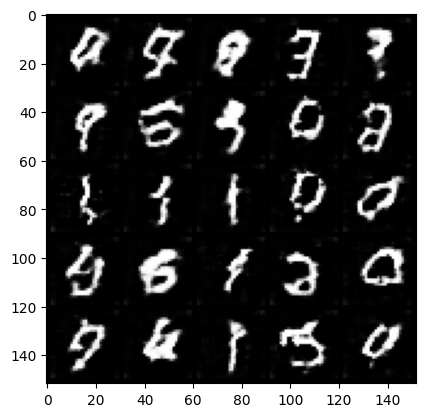

100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


Epoch: 2 | Disc loss:  0.6664 | Gen loss:  0.7901


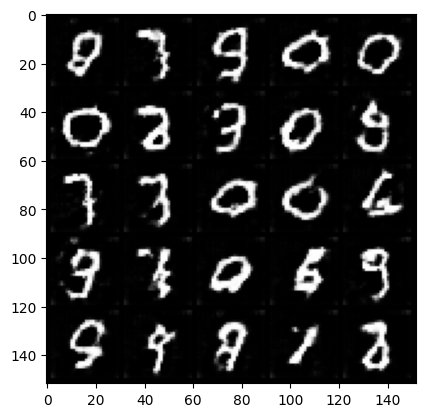

100%|██████████| 469/469 [00:16<00:00, 28.61it/s]


Epoch: 3 | Disc loss:  0.6743 | Gen loss:  0.7753


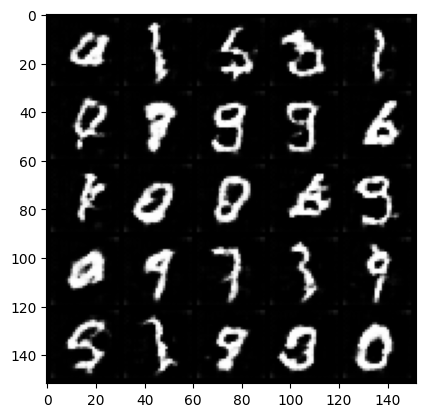

100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


Epoch: 4 | Disc loss:  0.6815 | Gen loss:  0.7574


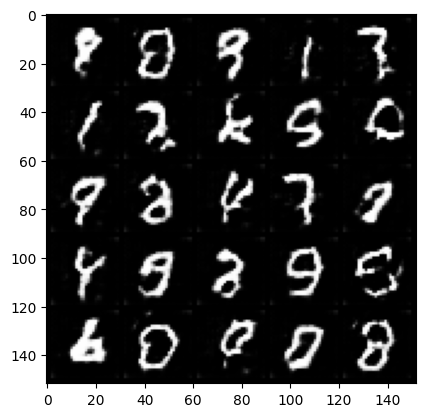

100%|██████████| 469/469 [00:16<00:00, 28.52it/s]


Epoch: 5 | Disc loss:  0.6863 | Gen loss:  0.7476


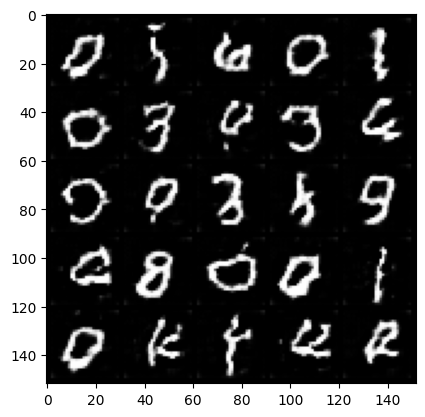

100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


Epoch: 6 | Disc loss:  0.6923 | Gen loss:  0.7326


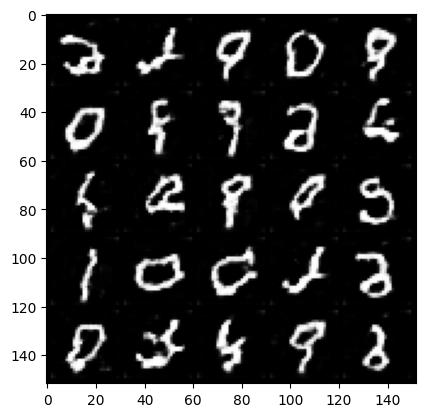

100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


Epoch: 7 | Disc loss:  0.6935 | Gen loss:  0.7304


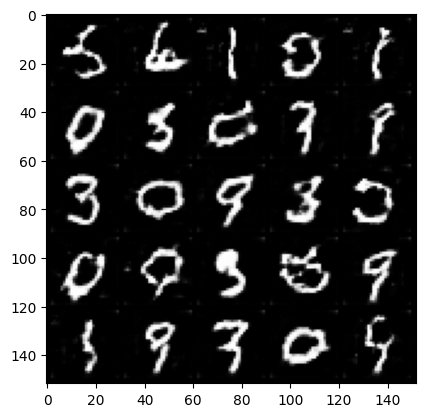

100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Epoch: 8 | Disc loss:  0.6961 | Gen loss:  0.7240


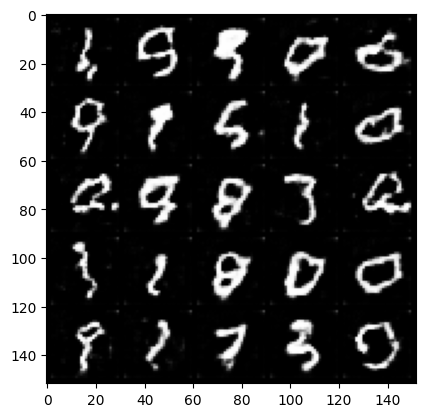

100%|██████████| 469/469 [00:16<00:00, 27.81it/s]


Epoch: 9 | Disc loss:  0.6974 | Gen loss:  0.7238


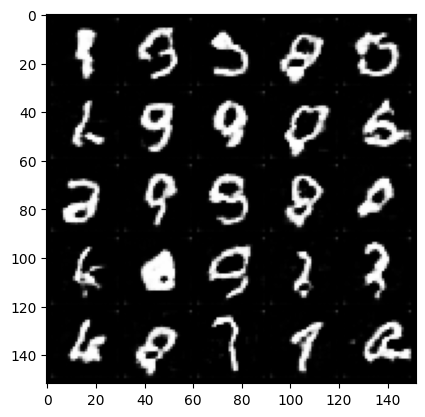

100%|██████████| 469/469 [00:16<00:00, 28.23it/s]


Epoch: 10 | Disc loss:  0.6993 | Gen loss:  0.7168


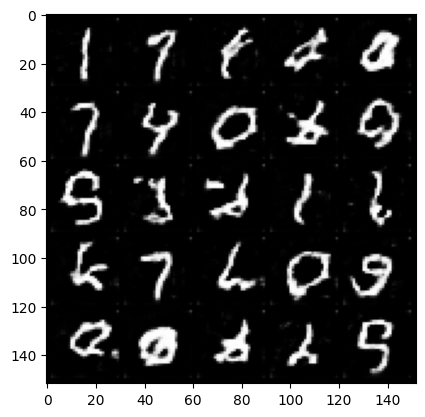

100%|██████████| 469/469 [00:16<00:00, 28.24it/s]


Epoch: 11 | Disc loss:  0.7013 | Gen loss:  0.7107


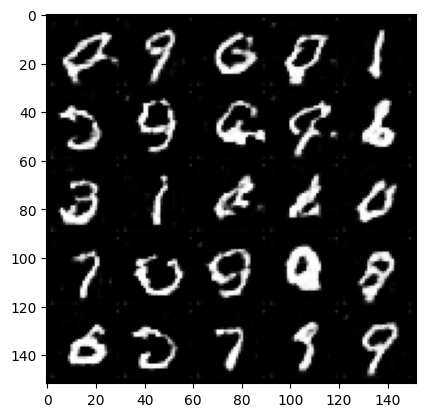

100%|██████████| 469/469 [00:16<00:00, 28.24it/s]


Epoch: 12 | Disc loss:  0.7003 | Gen loss:  0.7130


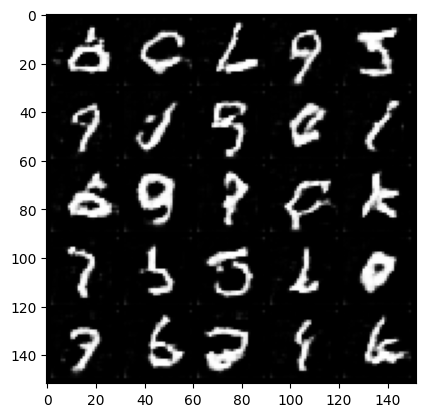

100%|██████████| 469/469 [00:16<00:00, 28.06it/s]


Epoch: 13 | Disc loss:  0.6993 | Gen loss:  0.7097


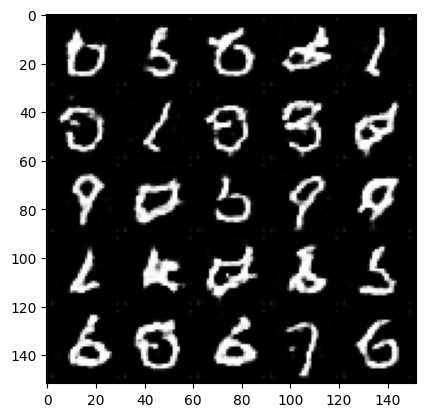

100%|██████████| 469/469 [00:16<00:00, 28.40it/s]


Epoch: 14 | Disc loss:  0.6992 | Gen loss:  0.7092


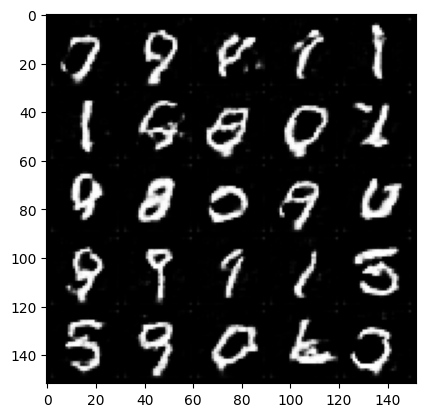

100%|██████████| 469/469 [00:16<00:00, 28.55it/s]


Epoch: 15 | Disc loss:  0.6999 | Gen loss:  0.7085


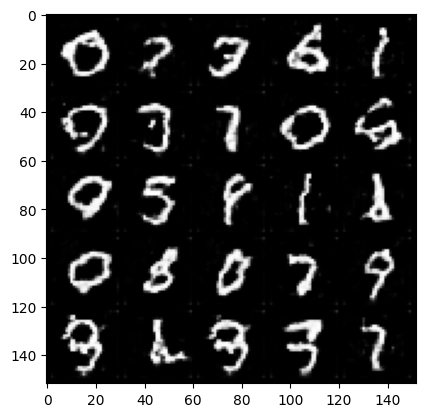

100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


Epoch: 16 | Disc loss:  0.7004 | Gen loss:  0.7060


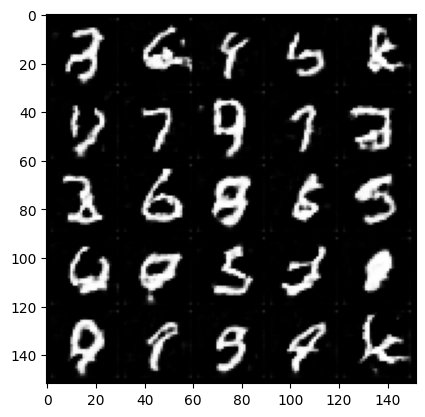

100%|██████████| 469/469 [00:16<00:00, 28.26it/s]


Epoch: 17 | Disc loss:  0.6985 | Gen loss:  0.7065


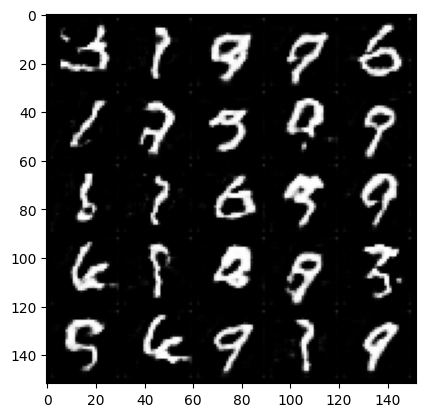

100%|██████████| 469/469 [00:16<00:00, 27.86it/s]


Epoch: 18 | Disc loss:  0.6989 | Gen loss:  0.7053


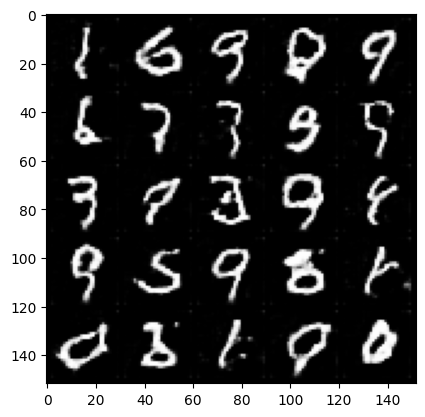

100%|██████████| 469/469 [00:17<00:00, 27.15it/s]


Epoch: 19 | Disc loss:  0.6981 | Gen loss:  0.7053


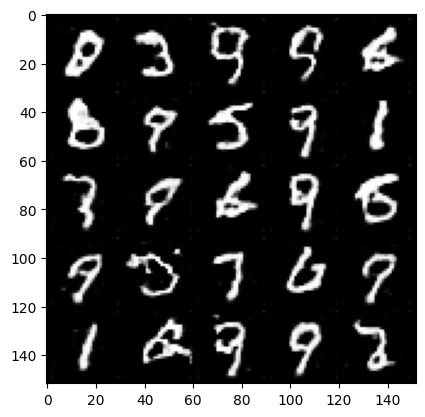

100%|██████████| 469/469 [00:17<00:00, 27.14it/s]


Epoch: 20 | Disc loss:  0.6983 | Gen loss:  0.7024


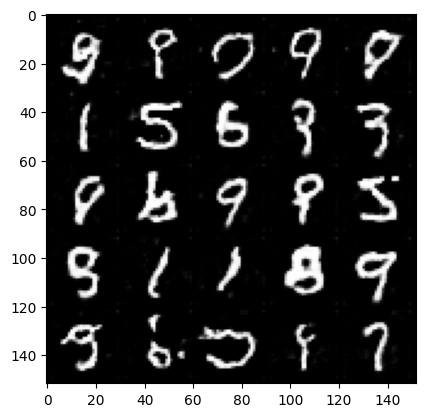

In [135]:
for epoch in range(epochs):

  samples_processes = 0.0
  running_disc_loss = 0.0
  running_gen_loss = 0.0

  bar = tqdm(dataloader_train)

  for images, labels in bar:

    images, labels = images.to(device), labels.to(device)
    current_batch_size = images.size(0)
    samples_processes += current_batch_size


    disc_loss = generate_disc_loss(gen, disc, current_batch_size, z_dim, images, optimizer_disc, criterion, device)
    gen_loss = generate_gen_loss(gen, disc, current_batch_size, z_dim, images, optimizer_gen, criterion, device)

    disc_loss *= current_batch_size
    gen_loss *= current_batch_size

    running_disc_loss += disc_loss
    running_gen_loss += gen_loss


  print(f'Epoch: {epoch + 1} | Disc loss: {running_disc_loss / samples_processes: .4f} | Gen loss: {running_gen_loss / samples_processes: .4f}')
  sample_noise = get_noise(BATCH_SIZE, z_dim, device)
  sample_fakes = gen(sample_noise)
  show_tensor_images(sample_fakes)
